We bring the imports we need

In [1677]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler


## Load dataset

We will use yfincance to get the data from *Microsoft*

In [1678]:
end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download("MSFT", start, end)
dataset.shape

[*********************100%%**********************]  1 of 1 completed


(2014, 6)

## Inspect dataset

Let's see the dataset that we have

In [1679]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-14,420.239990,427.820007,417.989990,425.220001,425.220001,34157300
2024-03-15,419.290009,422.600006,412.790009,416.420013,416.420013,45049800
2024-03-18,414.250000,420.730011,413.779999,417.320007,417.320007,20106000
2024-03-19,417.829987,421.670013,415.549988,421.410004,421.410004,19837900
2024-03-20,422.000000,425.959991,420.660004,425.230011,425.230011,17828300


Here we remove the last row and we save it in a new variable to use it to compare predicted price with the last price we have in the last row.

In [1680]:
last_row = dataset.iloc[-1]
dataset.drop(dataset.index[-1], inplace=True)


Let's check for null data

In [1681]:
dataset.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

We will check what type of data are the columns from dataset

In [1682]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2013 entries, 2016-03-21 to 2024-03-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2013 non-null   float64
 1   High       2013 non-null   float64
 2   Low        2013 non-null   float64
 3   Close      2013 non-null   float64
 4   Adj Close  2013 non-null   float64
 5   Volume     2013 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 110.1 KB


Let's check for duplicates

In [1683]:
dataset.duplicated().sum()

0

Let's observe the dataset in a plot

/usr/local/Caskroom/miniconda/base/envs/stock-prediction-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/Caskroom/miniconda/base/envs/stock-prediction-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


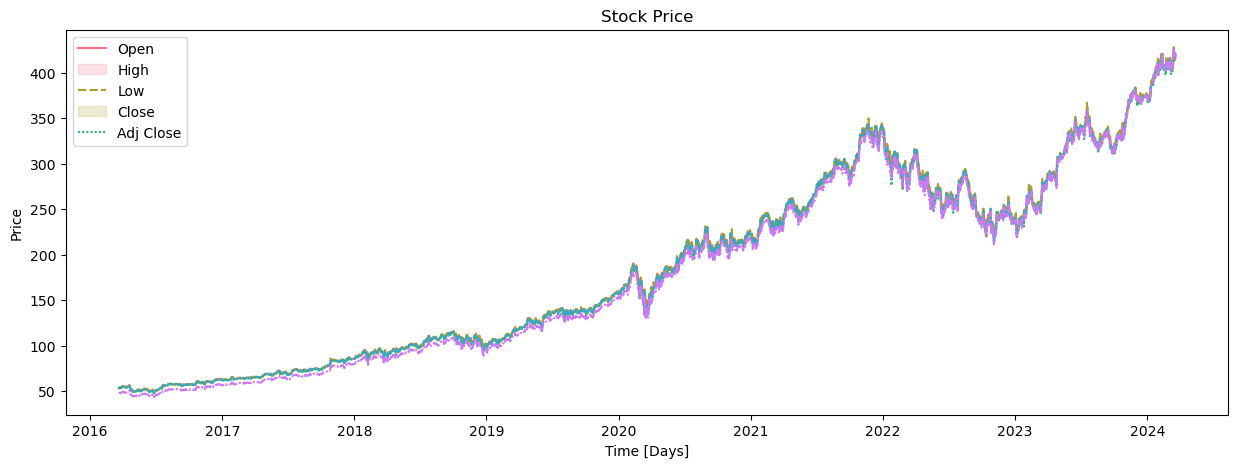

In [1684]:
plt.figure(figsize=(15, 5))
palette = sns.color_palette("husl", 5)
sns.lineplot(data=dataset[['Open', 'High', 'Low', 'Close', 'Adj Close']],palette=palette) 
plt.title('Stock Price')
plt.xlabel('Time [Days]')
plt.ylabel('Price')
plt.legend(labels=['Open', 'High', 'Low', 'Close', 'Adj Close'], loc='best')
plt.show()

In [1685]:
original_dataset = dataset

## Transform the data

We normalize the data

In [1686]:
scaler = MinMaxScaler()
columns_to_normalize = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
dataset[columns_to_normalize] = scaler.fit_transform(dataset[columns_to_normalize])

dataset.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-03-21,0.011651,0.012623,0.013218,53.860001,0.011918,0.130873
2016-03-22,0.012620,0.013468,0.014651,54.070000,0.012410,0.124515
2016-03-23,0.013965,0.013442,0.015407,53.970001,0.012175,0.100759
2016-03-24,0.013239,0.013679,0.015380,54.209999,0.012737,0.099339
2016-03-28,0.014234,0.013574,0.014299,53.540001,0.011169,0.076140


In [1687]:
close_scaler = MinMaxScaler()
columns_to_normalize = ['Close']
dataset[columns_to_normalize] = close_scaler.fit_transform(dataset[columns_to_normalize])


Splitting the data
X_train, y_train: Training set, used to train your model.
X_val, y_val: Validation set, used to evaluate model performance during training.
X_test, y_test: Test set, used to evaluate the final performance of your trained model.

In [1688]:
X = dataset[['Open', 'High', 'Low', 'Adj Close']]
y = dataset[['Close']]


X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, shuffle=False)

We sets the number of time steps to 10, meaning each sequence will contain 10 data points.
X_train_seq, y_train_seq = create_time_steps(X_train, time_steps): This creates sequences for the training data (X_train_seq contains input sequences, and y_train_seq contains corresponding labels).
X_val_seq, y_val_seq = create_time_steps(X_val, time_steps): This creates sequences for the validation data.
X_test_seq, y_test_seq = create_time_steps(X_test, time_steps): This creates sequences for the test data.

In [1689]:
def create_time_steps(data, time_steps):
    X = []
    y = []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i+time_steps])
        y.append(data.iloc[i+time_steps])
    return np.array(X), np.array(y)

# Define the number of time steps
time_steps = 10

# Create time steps sequences for training data
X_train_seq, y_train_seq = create_time_steps(X_train, time_steps)

# Create time steps sequences for validation data
X_val_seq, y_val_seq = create_time_steps(X_val, time_steps)

# Create time steps sequences for test data
X_test_seq, y_test_seq = create_time_steps(X_test, time_steps)


In [1690]:
X_test_seq.shape

(192, 10, 4)

## Create Model RNN Sequential LSTM

We create a sequential model using an LSTM layer followed by a Dense output layer
we are predicting the future value of the 'Close' price of a stock based on past values of the 'Open', 'High', 'Low', and 'Adj Close' prices.

Input: Each input sequence consists of past values of 'Open', 'High', 'Low', and 'Adj Close' prices, represented as a sequence of 10 time steps.
Output: The model is trained to predict the next value of the 'Close' price following the input sequence.

In [1691]:
model = Sequential([
    LSTM(units=128, activation='relu', input_shape=(time_steps , 4)),   
    Dense(units=1)  
    
])

Define the optimizer and compile the model

In [1692]:
opt = Adam(learning_rate=0.001)  # Adjust learning rate if necessary
model.compile(optimizer=opt, loss='mean_squared_error')

# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 15 == 0 and epoch != 0:
        lr = lr * 0.9  # Decrease learning rate by 10% every 10 epochs
    return lr

lr_callback = LearningRateScheduler(lr_scheduler)

We train the model :
X_train_seq: This is the input data that we use to train your model. Here X_train_seq contains sequences of past values of 'Open', 'High', 'Low', and 'Adj Close' prices, and each sequence has a length of 10 time steps.
y_train_seq: This is the target data that we try to predict during training. In this case, y_train_seq contains the next value of the 'Close' price corresponding to each sequence in X_train_seq.

In [1693]:
history = model.fit(X_train_seq, y_train_seq, epochs=100, validation_data=(X_val_seq, y_val_seq), callbacks=[lr_callback])


Epoch 1/100


50/50 [==============================] - 3s 14ms/step - loss: 0.0108 - val_loss: 5.4459e-04 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 0s 9ms/step - loss: 1.8572e-04 - val_loss: 4.0891e-04 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 0s 8ms/step - loss: 1.5974e-04 - val_loss: 4.1350e-04 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 0s 7ms/step - loss: 1.6220e-04 - val_loss: 4.0015e-04 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 0s 8ms/step - loss: 1.5073e-04 - val_loss: 3.8868e-04 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 0s 7ms/step - loss: 1.4945e-04 - val_loss: 3.8060e-04 - lr: 0.0010
Epoch 7/100
50/50 [==============================] - 0s 8ms/step - loss: 1.4810e-04 - val_loss: 4.6059e-04 - lr: 0.0010
Epoch 8/100
50/50 [==============================] - 0s 7ms/step - loss: 1.6271e-04 - val_loss: 3.9121e-04 - lr: 0.0010
Epoch 9/100
50/50 [==============================] - 0s

In [1694]:
validation_prediction=model.predict(X_val_seq)
test_predict=model.predict(X_test_seq)

6/6 [==============================] - 0s 3ms/step


In [1695]:
y_valid_inversed = close_scaler.inverse_transform(validation_prediction)
y_test_inversed = close_scaler.inverse_transform(test_predict)

In [1696]:
y_test_original = close_scaler.inverse_transform(y_test)

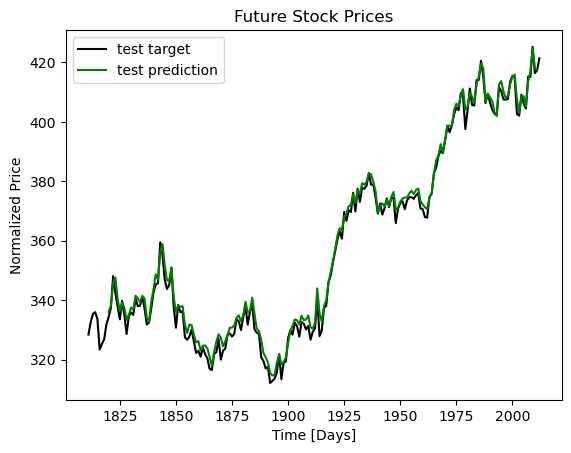

In [1697]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have defined y_train, y_test, validation_prediction, and test_predict

# Calculate the starting index for test data in the x-axis
start_index = y_train.shape[0] + y_val.shape[0]
end_index_first_plot = start_index + y_test.shape[0]
x_values_second_plot = np.arange(end_index_first_plot - test_predict.shape[0]-1, end_index_first_plot-1)


# Plotting
plt.plot(np.arange(start_index, start_index + y_test.shape[0]),
         y_test_original, color='black', label='test target')

plt.plot(x_values_second_plot,
         y_test_inversed, color='green', label='test prediction')

plt.title('Future Stock Prices')
plt.xlabel('Time [Days]')
plt.ylabel('Normalized Price')
plt.legend(loc='best')

plt.show()


## GRU model

We will create a GRU model to see how it will perform

In [1698]:
gru_model = Sequential([
    GRU(units=128, activation='relu', input_shape=(time_steps, 4)),
    #Dropout(0.2),  # Dropout layer for regularization
    Dense(units=1)  # Output layer for regression task
])

In [1699]:
opt = Adam(learning_rate=0.001)  # Adjust learning rate if necessary
gru_model.compile(optimizer=opt, loss='mean_squared_error')

# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr * 0.9  # Decrease learning rate by 10% every 10 epochs
    return lr

lr_callback = LearningRateScheduler(lr_scheduler)

In [1700]:
gru_history = gru_model.fit(X_train_seq, y_train_seq, epochs=100, validation_data=(X_val_seq, y_val_seq), callbacks=[lr_callback])

Epoch 1/100
50/50 [==============================] - 2s 12ms/step - loss: 0.0247 - val_loss: 3.6130e-04 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 0s 6ms/step - loss: 1.1194e-04 - val_loss: 3.2036e-04 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 0s 6ms/step - loss: 1.1796e-04 - val_loss: 2.4911e-04 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 0s 6ms/step - loss: 1.1983e-04 - val_loss: 2.6618e-04 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 0s 6ms/step - loss: 1.0205e-04 - val_loss: 2.3605e-04 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 0s 6ms/step - loss: 1.1350e-04 - val_loss: 2.7023e-04 - lr: 0.0010
Epoch 7/100
50/50 [==============================] - 0s 6ms/step - loss: 9.7744e-05 - val_loss: 2.2090e-04 - lr: 0.0010
Epoch 8/100
50/50 [==============================] - 0s 6ms/step - loss: 9.6158e-05 - val_loss: 2.2888e-04 - lr: 0.0010
Epoch 9/100
50/50 [========================

In [1701]:
validation_prediction=gru_model.predict(X_val_seq)
test_predict=gru_model.predict(X_test_seq)

6/6 [==============================] - 0s 3ms/step


In [1702]:
y_valid_inversed = close_scaler.inverse_transform(validation_prediction)
y_test_inversed = close_scaler.inverse_transform(test_predict)

In [1703]:
y_test_original = close_scaler.inverse_transform(y_test)

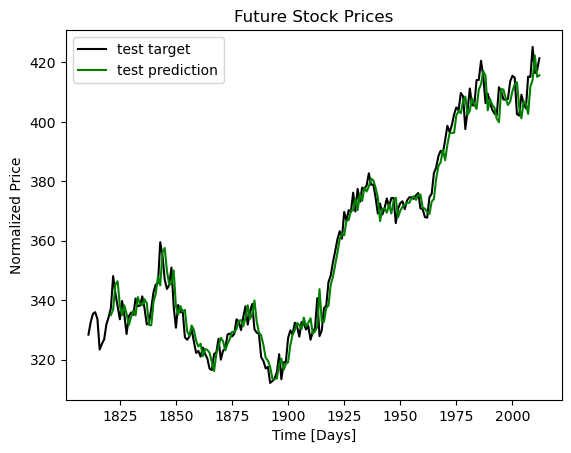

In [1704]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have defined y_train, y_test, validation_prediction, and test_predict

# Calculate the starting index for test data in the x-axis
start_index = y_train.shape[0] + y_val.shape[0]
end_index_first_plot = start_index + y_test.shape[0]
x_values_second_plot = np.arange(end_index_first_plot - test_predict.shape[0], end_index_first_plot)


# Plotting
plt.plot(np.arange(start_index, start_index + y_test.shape[0]),
         y_test_original, color='black', label='test target')

plt.plot(x_values_second_plot,
         y_test_inversed, color='green', label='test prediction')

plt.title('Future Stock Prices')
plt.xlabel('Time [Days]')
plt.ylabel('Normalized Price')
plt.legend(loc='best')

plt.show()

In [1705]:
last_sequence = X_test_seq[-1]
print(last_sequence)


[[0.98224086 0.96416403 0.95310184 0.94086207]
 [0.95266926 0.94015897 0.94701993 0.93939477]
 [0.96114519 0.95235955 0.95742668 0.95786722]
 [0.96609621 0.95404972 0.96307608 0.9502162 ]
 [0.954795   0.94153217 0.95477772 0.94576183]
 [0.96518135 0.96764993 0.96972569 0.97395521]
 [0.99338071 0.97454244 0.98232199 0.97348359]
 [0.99913893 1.         1.         1.        ]
 [0.99658274 0.98621491 0.9859441  0.97694227]
 [0.98302121 0.98127658 0.98862011 0.97930044]]


In [1712]:
last_sequence = last_sequence.reshape(1, time_steps, 4)

next_day_prediction = model.predict(last_sequence)
print(next_day_prediction)

print("LSTM_Model tomorrow price prediction: ",close_scaler.inverse_transform(next_day_prediction))

next_day_prediction = gru_model.predict(last_sequence)
print(next_day_prediction)

print("GRU_Model tomorrow price prediction: ",close_scaler.inverse_transform(next_day_prediction))

print("Tomorrow expected price: ",last_row['Close'])

1/1 [==============================] - 0s 31ms/step


[[0.9794485]]
LSTM_Model tomorrow price prediction:  [[417.4764]]
1/1 [==============================] - 0s 34ms/step
[[0.9746469]]
GRU_Model tomorrow price prediction:  [[415.6672]]
Tomorrow expected price:  425.2300109863281
